# Discrete Omega Metric Maximization 


## Intuition


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Risky Call Option
x1 = np.array([0.0, 0.5, 1.6, 2.0])
px1 = np.array([0.6, 0.3, 0.05, 0.05])

#Uniform Asset
x2 = np.array([0.0, 0.3, 1.5, 2.5])
px2 = np.array([0.25, 0.25, 0.25, 0.25])

#Biased Coin Flip Asset
x3 = np.array([0.0, 0.5, 1.5, 2.1])
px3 = np.array([0.5, 0.0, 0.0, 0.5])

#Shitty Asset 1
x4 = np.linspace(0, 1.3, num=50)
px4 = np.square(1.3 - x4)
px4 = px4/np.sum(px4)

#Shitty Asset 2
x5 = np.linspace(0.8, 1.2, num=50)
px5 = 1.0 - 25*np.square(x5 - 1.0)
px5 = px5/np.sum(px5)

#Shitty Asset 2
x6 = np.linspace(0.8, 1.2, num=50)
px6 = 1.0 - 25*np.square(x6 - 1.0)
px6 = px6/np.sum(px6)

x = [x1, x2, x3, x4, x5, x6]
px = [px1, px2, px3, px4, px5, px6]

In [2]:
#precomputations
E = [] #expected values of each distr
for i in range(len(x)):
    E.append(np.dot(x[i], px[i]))
    
print(E)


#Generate r_js
M = 100
R_sample = np.zeros((len(x), M)) #This sample matrix will be used to calculate omega

for i in range(len(x)):
    R_sample[i] = np.random.choice(x[i], M, p=px[i])
    

[0.33, 1.075, 1.05, 0.3151515151515152, 0.9999999999999998, 0.9999999999999998]


In [3]:
#helper functions
def denom(weights, returns, tau=0.0):
    term1 = np.maximum(tau-np.matmul(weights,R_sample), 0)
    #print(term1)
    denom = np.average(term1)
    return denom

def numerator(weights, returns, tau=0.0):
    return np.dot(weights, returns) - tau

def omega(weights, returns, tau=0.0):
    return numerator(weights, returns,tau=tau)/denom(weights, returns, tau=tau)

In [4]:
#w = np.ones(6)
#w = w/np.sum(w)
w = np.array([0.,        0.96929451, 0.01104542, 0.,         0.00983003, 0.00983003])
#w = np.array([0.02063728, 0.73970493, 0.07611008, 0.01965031, 0.0719487,  0.0719487 ])
print("Omega: ", omega(w, E, tau=1.0))
print("Denom (Sampled): ", denom(w, E, tau=1.0))
print("Numerator: ", numerator(w, E, tau=1.0))


Omega:  0.2046501298943436
Denom (Sampled):  0.35792476304714277
Numerator:  0.07324934924999993


In [5]:
def h_gradient(w, r, constr, tau=1.0, c=0.1):
    gradient_var = []
    gradient_constraint = []
    
    #Calculate objective function
    obj = denom(w, r, tau=tau)
    
    #Calculate slack variable at each step
    slack = np.dot(w, r) - tau - c
    if slack > 0.0:
        slack = np.sqrt(slack)
    else:
        slack = 0.0
        
    
    #Calculate gradients of lagrangian
    dl_dlambda1 = np.sum(w) - 1
    dl_dlambda2 = np.sum(np.abs(w)) - 1
    dl_dtheta = np.dot(w, r) - tau - c - np.square(slack) #can only be negative!
    
    dl_dw = np.zeros((len(w)))
    
    info_vector = tau - np.matmul(w, R_sample)
    for i in range(M):
        if info_vector[i] > 0.0:
            dl_dw += -R_sample[:, i]
    
    dl_dw /= M
    dl_dw += constr[0] + np.sign(w)*constr[1] + r*constr[2]
    
    #Now we calculate the gradients of h
    dh_dtheta = np.dot(r, dl_dw)
    dh_dlambda1 = np.sum(dl_dw)
    dh_dlambda2 = np.dot(np.sign(w), dl_dw)
    
    gradient_constraint.append(dh_dlambda1)
    gradient_constraint.append(dh_dlambda2)
    gradient_constraint.append(dh_dtheta)
    
    gradient_var = r*dl_dtheta + np.sign(w)*dl_dlambda2 + dl_dlambda1
    
    return gradient_var, gradient_constraint, obj
    
    
    
    

In [6]:
def h_gradient_descent(w, r, constr_var, steps=100, lr=1e-3, tau=1.0, c=0.1): 
    #We want to minimize the norm of the gradient
    #mu is the minimum expected value of the portfolio
    #I haven't implemented tolerance yet
    
    grad_history = []
    constr_grad_history = []
    obj_history = []
    port_var_history = []
    constr_history = []
    var_np = np.array(w)
    
    constr_np = np.array(constr_var)
    
    for _ in range(steps):
        grad, grad_constr, obj = h_gradient(var_np, r, constr_np, tau=tau, c=c)
        var_np -= lr*grad
        #var_np = np.maximum(var_np, 0)
        #var_np = 
        constr_np -= lr*np.array(grad_constr)
        
        port_var_history.append(var_np.copy())
        constr_history.append(constr_np.copy())
        grad_history.append(grad)
        constr_grad_history.append(grad_constr)
        obj_history.append(obj)
    
    return port_var_history, grad_history, constr_history, constr_grad_history, obj_history, var_np

In [7]:
#variables = [0.,        0.96929451, 0.01104542, 0.,         0.00983003, 0.00983003]
#variables = [0.01833521, 0.25597163, 0.24799725, 0.01359892, 0.2320485,  0.2320485 ]
#variables = [-6.85918410e-05,  3.65793644e-01,  2.99642003e-01, -4.45200788e-05, 1.67338732e-01,  1.67338732e-01]
#variables = [-1.79233122e-12,  4.44444435e-01,  3.33333326e-01,  1.31158227e-12, 1.11111119e-01,  1.11111119e-01]
variables = np.random.randn(len(x))
tau=1.0
variables = variables/np.sum(variables) #random distribution starting point
constraints = [0.0, 0.0, 1.0]
var_history, grad_history, c_history, cgrad_history, obj_history, opt_var = h_gradient_descent(variables, 
                                                                                                          np.array(E), 
                                                                                                          constraints, 
                                                                                                          lr=3e-2, 
                                                                                                          steps=200000, 
                                                                                                          tau=tau,
                                                                                                          c=0.05)

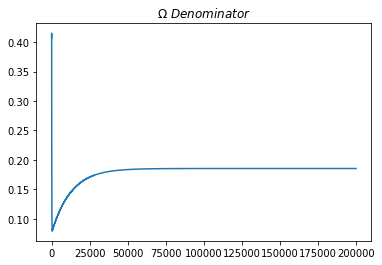

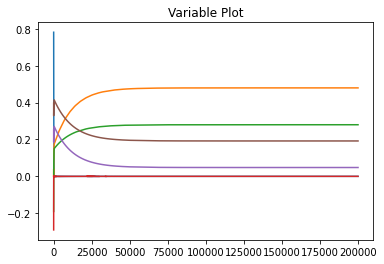

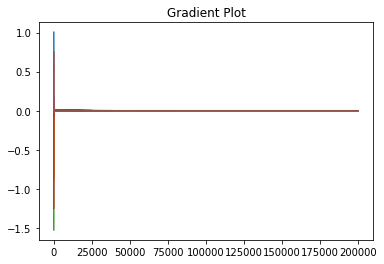

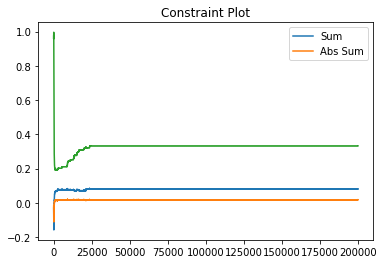

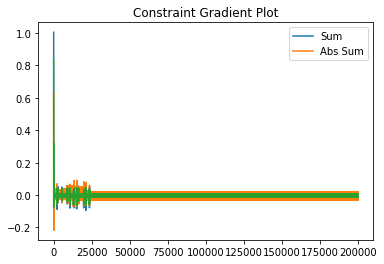

Optimal Portfolio:  [-3.16256820e-12  4.79972374e-01  2.80041401e-01  2.31432741e-12
  4.79531621e-02  1.92033063e-01]
Portfolio Sum Sanity Check:  1.0000000006351877
Normalized Portfolio:  [-3.16256819e-12  4.79972374e-01  2.80041401e-01  2.31432741e-12
  4.79531620e-02  1.92033063e-01]
Old Portfolio Omega(): -0.8032698626744259
Old Portfolio E[Z]:  0.6731224408378581
New Portfolio Omega():  0.26977366506157685
New Portfolio E[Z]:  1.0499999980991983
Constraints:  [0.08064779 0.01803098 0.33237674]
Constraint Gradients:  [-0.0279793318726968, -0.028086938524050697, -0.01197961923517038]


In [8]:
plt.plot(obj_history)
plt.title("$\Omega \ Denominator$")
plt.show()

plt.plot(var_history)
plt.title("Variable Plot")
plt.show()
plt.plot(grad_history)
plt.title("Gradient Plot")
plt.show()

plt.plot(c_history)
plt.title("Constraint Plot")
plt.legend(["Sum", "Abs Sum"])
plt.show()
plt.plot(cgrad_history)
plt.title("Constraint Gradient Plot")
plt.legend(["Sum", "Abs Sum"])
plt.show()
print("Optimal Portfolio: ", opt_var)
print("Portfolio Sum Sanity Check: ", np.sum(opt_var))
opt_var = opt_var/np.sum(opt_var)
print("Normalized Portfolio: ", opt_var)
print("Old Portfolio Omega():", omega(variables, E, tau=tau))
print("Old Portfolio E[Z]: ", np.dot(variables, E))

print("New Portfolio Omega(): ", omega(opt_var, E, tau=tau))
print("New Portfolio E[Z]: ", np.dot(opt_var, E))
print("Constraints: ", c_history[-1])
print("Constraint Gradients: ", cgrad_history[-1])